# Pedagogical example of a multi-fidelity Gaussian process

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import emukit
import GPy

In [2]:
from emukit.model_wrappers.gpy_model_wrappers import GPyMultiOutputWrapper
from emukit.multi_fidelity.models import GPyLinearMultiFidelityModel
from emukit.multi_fidelity.convert_lists_to_array import convert_x_list_to_array, convert_xy_lists_to_arrays

## Toy data 

In [3]:
# Generate synthetic multi-fidelity data
np.random.seed(1234)
x = np.linspace(-0.1, 1.1, 100)
x1 = np.linspace(0, 1, 20)
x2 = np.random.random(10)
y_low_f = np.sin(x*5*np.pi)- 2*x
y_low_samples = np.sin(x1*5*np.pi) - 2*x1
y_high_f = np.sin(x*5*np.pi) 
y_high_samples = np.sin(x2*5*np.pi)
#np.random.seed(None)

In [4]:
# Concatenate data into the format expected by Emukit
X_train, Y_train = convert_xy_lists_to_arrays(
    [x1.reshape(-1,1), x2.reshape(-1,1)], [y_low_samples.reshape(-1,1), y_high_samples.reshape(-1,1)])
X_plot = convert_x_list_to_array([x.reshape(-1,1), x.reshape(-1,1)])

## Create GPy multi-fidelity model

In [5]:
# Define the multi-fidelity kernels and wrap them with emukit
kernels = [GPy.kern.RBF(1), GPy.kern.RBF(1)]
lin_mf_kernel = emukit.multi_fidelity.kernels.LinearMultiFidelityKernel(
    kernels)

# Create the GPy multi-fidelity model
gpy_lin_mf_model = GPyLinearMultiFidelityModel(
    X_train, Y_train, lin_mf_kernel, n_fidelities=2)

# Fix noise to be non-zero to avoid convergence issues
gpy_lin_mf_model.mixed_noise.Gaussian_noise.fix(0.01) 
gpy_lin_mf_model.mixed_noise.Gaussian_noise_1.fix(0.01)

array([0])

In [6]:
# Wrap the GPy model in an Emukit wrapper and optimize
lin_mf_model = GPyMultiOutputWrapper(
    gpy_lin_mf_model, 2, n_optimization_restarts=10)
lin_mf_model.optimize()

Optimization restart 1/10, f = 37.05147610315504
Optimization restart 2/10, f = -0.8573459968546713
Optimization restart 3/10, f = -0.8573459968547992
Optimization restart 4/10, f = -0.8573459968507926
Optimization restart 5/10, f = 40.167490632535745
Optimization restart 6/10, f = -0.857345996854308
Optimization restart 7/10, f = -0.8573459952508653
Optimization restart 8/10, f = 42.1529328608046
Optimization restart 9/10, f = -0.857345996854022
Optimization restart 10/10, f = 406.8330745405366


In [7]:
# Create multi-fidelity inference inputs 
X_plot_low = X_plot[:100]
X_plot_high = X_plot[100:]
X_plot2 = convert_x_list_to_array([x2.reshape(-1,1), x2.reshape(-1,1)])

In [8]:
# Multi-fidelity predictions
hf_mean_lin_mf_model, hf_var_lin_mf_model = lin_mf_model.predict(X_plot_high)
hf_std_lin_mf_model = np.sqrt(hf_var_lin_mf_model)

lf_mean_lin_mf_model, lf_var_lin_mf_model = lin_mf_model.predict(X_plot_low)
lf_std_lin_mf_model = np.sqrt(lf_var_lin_mf_model)

In [9]:
# Create pseudo samples from the low-fidelity model to plot with error bars
lf_mean_lin_mf_model2, lf_var_lin_mf_model2 = lin_mf_model.predict(X_plot2[:10])
lf_std_lin_mf_model2 = np.sqrt(lf_var_lin_mf_model2)

## High-fidelity GP baseline

In [10]:
# GP model setup and optimisation
kernel = GPy.kern.RBF(1)
mean_function = GPy.mappings.Constant(input_dim=1, output_dim=1)
m = GPy.models.GPRegression(x2.reshape(-1,1), y_high_samples.reshape(-1,1), kernel, mean_function=mean_function)
m.optimize_restarts(num_restarts=10)
m.Gaussian_noise.fix(0.01)
m.optimize()

Optimization restart 1/10, f = -2.8614874073526115
Optimization restart 2/10, f = -2.8614874553253387
Optimization restart 3/10, f = -2.8614868764930943
Optimization restart 4/10, f = 8.948293037414915
Optimization restart 5/10, f = 8.94829501086138
Optimization restart 6/10, f = -2.861487163785559
Optimization restart 7/10, f = 8.948293043052697
Optimization restart 8/10, f = 8.948293035404092
Optimization restart 9/10, f = 8.948295341608636
Optimization restart 10/10, f = -2.8614873810980868


In [11]:
# Inference
hf_mean_gp_model, hf_var_gp_model = m.predict(x.reshape(-1,1))
hf_std_gp_model = np.sqrt(hf_var_gp_model)

## Plot

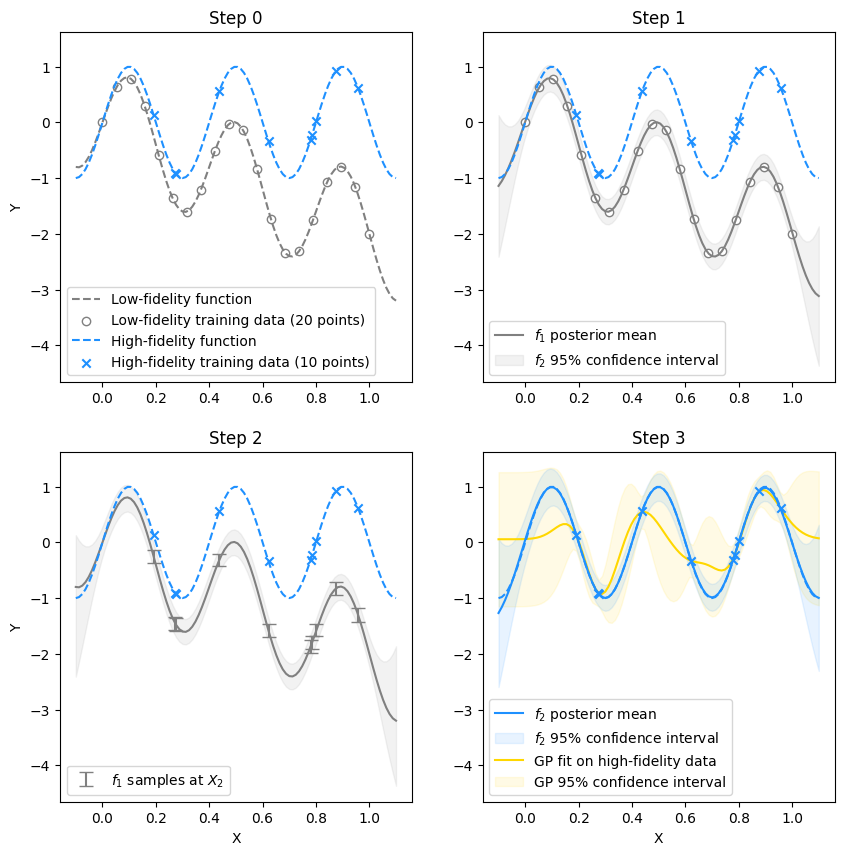

In [12]:
fig, axes = plt.subplots(2,2,figsize=(10,10), sharex=True, sharey=True)

# Step 0
axes[0,0].plot(x, y_low_f, linestyle="--", color="gray", label="Low-fidelity function")
axes[0,0].scatter(x1, y_low_samples, edgecolors="grey", facecolor='white', marker="o", label="Low-fidelity training data (20 points)")
axes[0,0].plot(x, y_high_f, linestyle="--", color="dodgerblue", label="High-fidelity function")                                                                                                                                                                                                                                                         
axes[0,0].scatter(x2, y_high_samples, color="dodgerblue",
                   marker="x", label="High-fidelity training data (10 points)")
axes[0,0].set_ylabel("Y")
axes[0, 0].legend()
axes[0,0].set_title("Step 0")


# Step 1
axes[0, 1].plot(x, lf_mean_lin_mf_model, linestyle="-", color="gray",
                label="$f_1$ posterior mean")
axes[0, 1].fill_between(x, (lf_mean_lin_mf_model-1.96 *lf_std_lin_mf_model).reshape(-1),
                            (lf_mean_lin_mf_model+1.96*lf_std_lin_mf_model).reshape(-1), 
                            label="$f_2$ 95% confidence interval",
                            color='gray',
                            alpha=0.1)
axes[0, 1].scatter(x1, y_low_samples, edgecolors="grey", facecolor='white',
                   marker="o")
axes[0, 1].plot(x, y_high_f, linestyle="--", color="dodgerblue")
axes[0, 1].scatter(x2, y_high_samples, color="dodgerblue",marker="x")
axes[0, 1].set_title("Step 1")
axes[0, 1].legend()

# Step 2
axes[1, 0].plot(x, y_low_f, linestyle="-", color="gray")
axes[1, 0].fill_between(x, (lf_mean_lin_mf_model-1.96 * lf_std_lin_mf_model).reshape(-1),
                        (lf_mean_lin_mf_model+1.96*lf_std_lin_mf_model).reshape(-1),
                        color='gray',
                        alpha=0.1)
axes[1, 0].plot(x, y_high_f, linestyle="--", color="dodgerblue")
axes[1, 0].errorbar(x2, lf_mean_lin_mf_model2.reshape(-1), yerr=lf_std_lin_mf_model2.reshape(-1), color="gray",
                    capsize=5, linestyle='', label="$f_1$ samples at $X_2$")
axes[1, 0].scatter(x2, y_high_samples, color="dodgerblue", marker="x")
axes[1, 0].set_title("Step 2")
axes[1, 0].set_ylabel("Y")
axes[1, 0].set_xlabel("X")
axes[1, 0].legend(loc='lower left')

# Step 3

axes[1, 1].plot(x, y_high_f, linestyle="--", color="dodgerblue")
axes[1, 1].plot(x, hf_mean_lin_mf_model, linestyle="-", color="dodgerblue",
                label="$f_2$ posterior mean")
axes[1, 1].fill_between(x, (hf_mean_lin_mf_model - 1.96*hf_std_lin_mf_model).reshape(-1),
                        (hf_mean_lin_mf_model + 1.96 *
                         hf_std_lin_mf_model).reshape(-1),
                        label="$f_2$ 95% confidence interval",
                        color='dodgerblue',
                        alpha=0.1)

axes[1, 1].plot(x, hf_mean_gp_model, linestyle="-", color="gold",
                label="GP fit on high-fidelity data", zorder=1)
axes[1, 1].fill_between(x, (hf_mean_gp_model - 1.96*hf_std_gp_model).reshape(-1),
                        (hf_mean_gp_model + 1.96 *
                         hf_std_gp_model).reshape(-1),
                        label="GP 95% confidence interval",
                        color='gold',
                        alpha=0.1, zorder=0)

axes[1, 1].scatter(x2, y_high_samples, color="dodgerblue", marker="x")
axes[1, 1].set_title("Step 3")
axes[1, 1].set_xlabel("X")
axes[1, 1].legend()

axes[0, 0].xaxis.set_tick_params(labelbottom=True)
axes[0, 1].xaxis.set_tick_params(labelbottom=True)
axes[0, 1].yaxis.set_tick_params(labelbottom=True)
axes[1, 1].yaxis.set_tick_params(labelbottom=True)

#plt.savefig("method_plot.pdf", dpi=300, bbox_inches="tight")